In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from keras import datasets
import matplotlib.pyplot as plt

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent))

# Import the module from the custom library
from src.models.data_loader import DataLoader
from src.models import TrainingArguments, LabeledData
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, loss_functions, optimizers, activations, metrics, callbacks
from src.architectures.alexnet import AlexNet, AlexNetConfig, Conv2DConfig, DenseConfig, MaxPoolConfig, LocalResponseNormConfig

### Constants and hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'alexnet_cifar_10')

In [3]:

train_test_split_pct = 0.1 # Percentage of samples to use for testing
train_valid_split = 0.1 # Percentage of samples to use for validation
learning_rate = 3e-4 # Learning rate for the optimizer
batch_size = 16 # Number of samples to use for each batch
epochs = 30 # Number of epochs to train the model
weight_decay = 5e-3 # Weight decay for the optimizer
seed = 1234 # Seed for reproducibility

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Extract the number of classes in the dataset
num_classes = len(np.unique(train_labels))

# Convert the lists to numpy arrays
X_train = Tensor(np.array(train_images))
y_train = Tensor(np.array(train_labels)[:, 0], dtype=np.int8)
X_test = Tensor(np.array(test_images))
y_test = Tensor(np.array(test_labels)[:, 0], dtype=np.int8)

# Split the training set into training, validation and testing sets
X_train, X_valid, y_train, y_valid = data_processing.split_data(data=(X_train, y_train), split_pct=train_valid_split, shuffle=True)[0]

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (45000, 32, 32, 3) (45000,)
Validation set: (5000, 32, 32, 3) (5000,)
Testing set: (10000, 32, 32, 3) (10000,)


### Data preprocessing

In [6]:
# Normalization
def normalize(X: Tensor) -> Tensor:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (Tensor): The input data to normalize
    
    Returns:
    - Tensor: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [7]:
# Convert the target values to one-hot encoded vectors
y_train_encoded = data_processing.one_hot_encoding(y=y_train, n_classes=num_classes)
y_valid_encoded = data_processing.one_hot_encoding(y=y_valid, n_classes=num_classes)

# Print one sample encoding
print("Sample target value:", y_train[0])
print("One-hot encoded value:", y_train_encoded[0])

Sample target value: Tensor(2.0, shape=(), dtype=float32)
One-hot encoded value: Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


### Data visualization

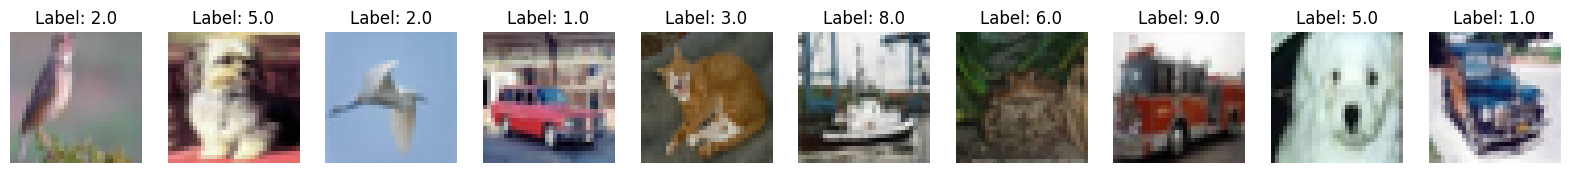

In [8]:
def plot_samples(samples: list[np.ndarray], labels: list[np.ndarray]) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
        
    # Plot the samples in a grid
    _, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
# Plot the first 10 samples
plot_samples(list(X_train.data[:10]), list(y_train.data[:10]))

### Building the model

In [9]:
# Create a smaller version of the AlexNet configuration for CIFAR-10
model = AlexNet(
    name = "AlexNet CIFAR-10 Classifier",
    config = AlexNetConfig(
        num_classes = num_classes,
        dropout_rate = 0.4,
        conv_layers = [
            Conv2DConfig(num_filters=16, kernel_size=(3, 3), stride=(1, 1), padding="same", activation=activations.ReLU()),
            Conv2DConfig(num_filters=32, kernel_size=(3, 3), stride=(1, 1), padding="same", activation=activations.ReLU()),
            Conv2DConfig(num_filters=64, kernel_size=(3, 3), stride=(1, 1), padding="same", activation=activations.ReLU()),
            Conv2DConfig(num_filters=64, kernel_size=(3, 3), stride=(1, 1), padding="same", activation=activations.ReLU()),
            Conv2DConfig(num_filters=32, kernel_size=(3, 3), stride=(1, 1), padding="same", activation=activations.ReLU())
        ],
        dense_layers = [
            DenseConfig(num_units=512, activation=activations.ReLU()),
            DenseConfig(num_units=256, activation=activations.ReLU())
        ],
        local_response_norm = LocalResponseNormConfig(size=3),
        max_pool = MaxPoolConfig(size=(2, 2), stride=(2, 2), padding="valid")
    ) 
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Initialize the loss function
loss_fn = loss_functions.CrossEntropy(label_smoothing=0.1)

### Initializing the model

In [10]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    model(X_train[:batch_size])

In [11]:
# Display the model summary
model.summary()
model.modules[0].summary(recursive=True)


AlexNet CIFAR-10 Classifier

-----------------------------------------------------------------------------------------------
Module (type)                                          Output Shape        Trainable params #  
alex_net_cifar-10_classifier.modules (ModuleList)      (16, 10)            475530              
Total trainable parameters: 475530
-----------------------------------------------------------------------------------------------
module_list.0 (AlexNetModule) [output_shape=(16, 10), params=475530]
├── alex_net.conv_1 (Conv2D) [output_shape=(16, 32, 32, 16), params=448]
├── alex_net.conv_2 (Conv2D) [output_shape=(16, 16, 16, 32), params=4640]
├── alex_net.conv_3 (Conv2D) [output_shape=(16, 8, 8, 64), params=18496]
├── alex_net.conv_4 (Conv2D) [output_shape=(16, 8, 8, 64), params=36928]
├── alex_net.conv_5 (Conv2D) [output_shape=(16, 8, 8, 32), params=18464]
├── alex_net.norm (LocalResponseNormalization) [output_shape=(16, 16, 16, 32), params=0]
├── alex_net.fc_1 (Dense) [

### Training the model

In [12]:
# Create the training arguments
train_arguments = TrainingArguments(
    data_loader = DataLoader(
        train_data = LabeledData(input={'x': X_train}, target=y_train_encoded),
        valid_data = LabeledData(input={'x': X_valid}, target=y_valid_encoded)
    ),
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_batch_size = batch_size,
    num_epochs = epochs,
    metrics = [metrics.accuracy],
    callbacks = [callbacks.EarlyStopping(monitor="val_loss", patience=5)],
    gradient_accumulation_steps = 4,
)

# Fit the model
history = model.fit(train_arguments)

Epoch 1/30 --> loss: 1.9505 - accuracy: 0.32568 | val_loss: 1.7311 - val_accuracy: 0.44589                                                           
Epoch 2/30 --> loss: 1.7005 - accuracy: 0.45232 | val_loss: 1.5915 - val_accuracy: 0.51198                                                           
Epoch 3/30 --> loss: 1.5915 - accuracy: 0.5128 | val_loss: 1.5385 - val_accuracy: 0.53934                                                            
Epoch 4/30 --> loss: 1.5244 - accuracy: 0.54848 | val_loss: 1.4861 - val_accuracy: 0.5631                                                            
Epoch 5/30 --> loss: 1.4781 - accuracy: 0.57368 | val_loss: 1.4231 - val_accuracy: 0.59864                                                           
Epoch 6/30 --> loss: 1.4323 - accuracy: 0.59774 | val_loss: 1.4026 - val_accuracy: 0.60903                                                           
Epoch 7/30 --> loss: 1.3983 - accuracy: 0.61476 | val_loss: 1.3598 - val_accuracy: 0.6252           

In [13]:
# Save the model
model.save(model_path)

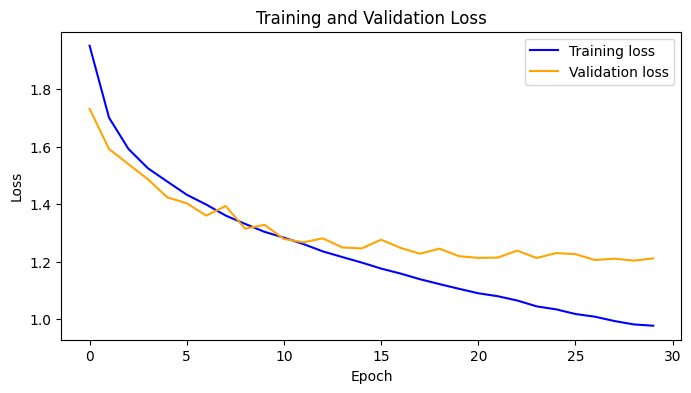

In [14]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = history["loss"], 
    valid_loss = history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)

### Evaluation

In [15]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    preds = model(X_test, batch_size=batch_size, verbose=True)

# Apply the argmax function to the predictions
predictions = Tensor(np.argmax(preds.output.data, axis=1), dtype=np.int8)

Processing batch 625/625 - 7.74 ms/step

Accuracy: 0.70


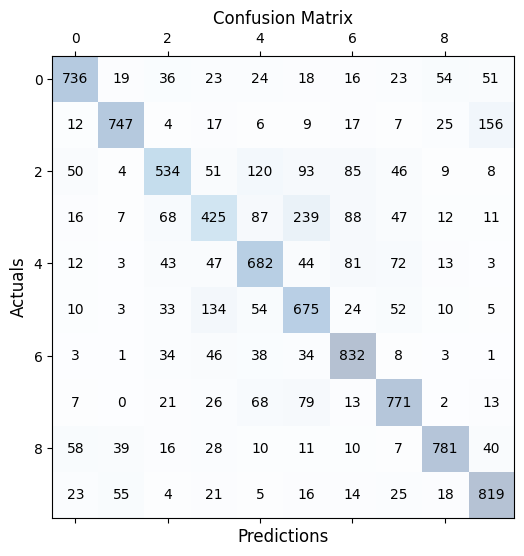

In [16]:
# Compute the accuracy
accuracy = metrics.accuracy(y_test, predictions)
confusion_matrix = metrics.confusion_matrix(num_classes, y_test, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy.data:.2f}")

# Plot the confusion matrix
data_analysis.plot_confusion_matrix(confusion_matrix)